#  <center> Controls on diabatic eddies </center> #

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import os
from pylab import *
import sys
sys.path.append('/noc/users/hb1g13/Python/python_functions/')
import layers_calc_numba
import APE_Calc as AC
sys.path.append('/noc/users/hb1g13/Python/python_functions/MITgcmUtils/')
import utils
%matplotlib inline

In [5]:
tau = ['50', '250', '500', '1000', '2000', '3000', '10000']
Figletter = ['a) ', 'b) ', 'c) ', 'd) ', 'e)', 'f) ', 'g) ', 'h) ', 'j) ']
# Path root
x = '/noc/msm/scratch/students/hb1g13/Mobilis/Vary_N/'
# Now Make file structure
check = 0
runs = []
for i in range(len(tau)):
    flist = x+'/'+str(tau[i])+'m/VSQ.nc'
    if not os.path.exists(flist):
        print ' WARNING: '+flist+' does not exist! (skipping this tau...)'
        check += 0
    else:
        check += 1
        runs.append(i)
Runs = np.array(runs)

In [44]:
Dsum = []
Vsum = []
Darea = []
APEt = []
for i in range(len(Runs)):
    fname = x+'/'+str(tau[Runs[i]])+'m/'
    c = utils.ChannelSetup(output_dir=str(fname))
    # PLOT PANNELS
    CellVol = c.rac*np.tile(c.dzf,(c.Nx,c.Ny,1)).T
    # load V, W, T bar    
    # put everything on the C Grid                        
    VT = (c.mnc('Tav_VT.nc','VVELTH'))
    WT = (c.mnc('Tav_VT.nc','WVELTH'))
    Tv = utils.cgrid_to_vgrid(c.mnc('Tav.nc','THETA'))
    Tw = utils.cgrid_to_wgrid(c.mnc('Tav.nc','THETA'))
    V = (c.mnc('Tav.nc','VVEL'))
    W = (c.mnc('Tav.nc','WVEL'))
    npad = ((0, 1), (0, 0), (0, 0))
    W = np.pad(W, pad_width=npad, mode='constant', constant_values=0)
    WT = np.pad(WT, pad_width=npad, mode='constant', constant_values=0)

    Ty = (Tv[:,0:-1,:] - Tv[:,1::,:])*CellVol
    Tz = (Tw[1::,:,:] - Tw[0:-1,:,:])*CellVol
 
    g = layers_calc_numba.LayersComputer(c)
    # ROC 
    psiz = c.get_psi_iso_z()
    dPz = c.ddz_cgrid_centered(psiz*Ty.mean(axis=2)/5000)
    dPy = c.ddy_cgrid_centered(psiz*Tz.mean(axis=2)/5000)
    ROC = np.sum((dPz+dPy),axis=0)/np.sum(CellVol.mean(axis=2)/5000)
    
    # Diabatic eddis from new def
    dx = 5000
    nx = 200
    Dz = (dx*((WT[1::, :, :]-WT[0:-1, :, :])*CellVol).mean(axis=2)/nx -
             c.ddz_cgrid_centered(psiz*Ty.mean(axis=2)/5000))
    Dy = (dx*((VT[:, 1::, :]-VT[:, 0:-1, :])*CellVol).mean(axis=2)/nx -
             c.ddy_cgrid_centered(psiz*Tz.mean(axis=2)/5000))
    D = np.sum((Dz+Dy), axis=0)/np.sum(CellVol.mean(axis=2))

        
    
      
    # Diabatic layer area
    PI = c.mnc('PSI.nc',"LaPs1TH").mean(axis=2)
    PI = ma.masked_array(PI,PI<0.95)
    
    # Depths
    th = c.mnc('PSI.nc',"LaHs1TH").mean(axis=2)
    depths = np.cumsum(th[::-1],axis=0)[::-1]
    DDL = np.zeros(len(c.yc))
    psi = c.get_psi_iso()
    for jj in range(len(c.yc)):
        if ma.all(PI[:,jj]  == 1)  or np.all(psi[:,jj] == -0) or PI[:,jj].mask.all():
            continue
        indx = ma.nonzero(PI[:,jj]<1)[0]
        b = indx#[np.nonzero(indx>3)[0]]
        if len(b)>=2 and (b[1]-b[0])>1:
            a = b[1]
        else:
            a = b[0]
        if a<41 and depths[a-1,jj] - depths[a,jj] > 150:
            a = a-1
        DDL[jj] = depths[a,jj]
    
    # Diabatic area mask
    Zmatrix = np.tile(c.zc,(c.Ny,1)).T
    for jj in range(c.Ny):
        Zval = -Zmatrix[:,jj]
        Zmatrix[Zval>DDL[jj],jj] = 0
        #Zmatrix[Zval<=DDL[jj],jj] = 1
    V = c.calc_EKE()
    g = AC.APEcomputer(c)
    APE = g.calc_APE()
    if i == 0:
        ROC0 = np.sum(abs(ROC))
        D0 = np.sum(abs(D))
        V0 = np.sum(abs(V)*CellVol.mean(axis=2))
        APE0 = np.sum(APE.mean(axis=1))
       
    
    incD = (np.sum(abs(D))-D0)/D0
    incV = (np.sum(abs(V)*CellVol.mean(axis=2))-V0)/V0
    incDdl = (np.sum(DDL)-DDL0)/DDL0
    incAPE = (np.sum(APE.mean(axis=1))-APE0)/APE0
    
    Dsum.append(incD)
    Vsum.append(incV)
    Darea.append(incDdl)
    APEt.append(incAPE)
Dsum = np.array(Dsum)
Vsum = np.array(Vsum)
Darea = np.array(Darea)
APEt = np.array(APEt)

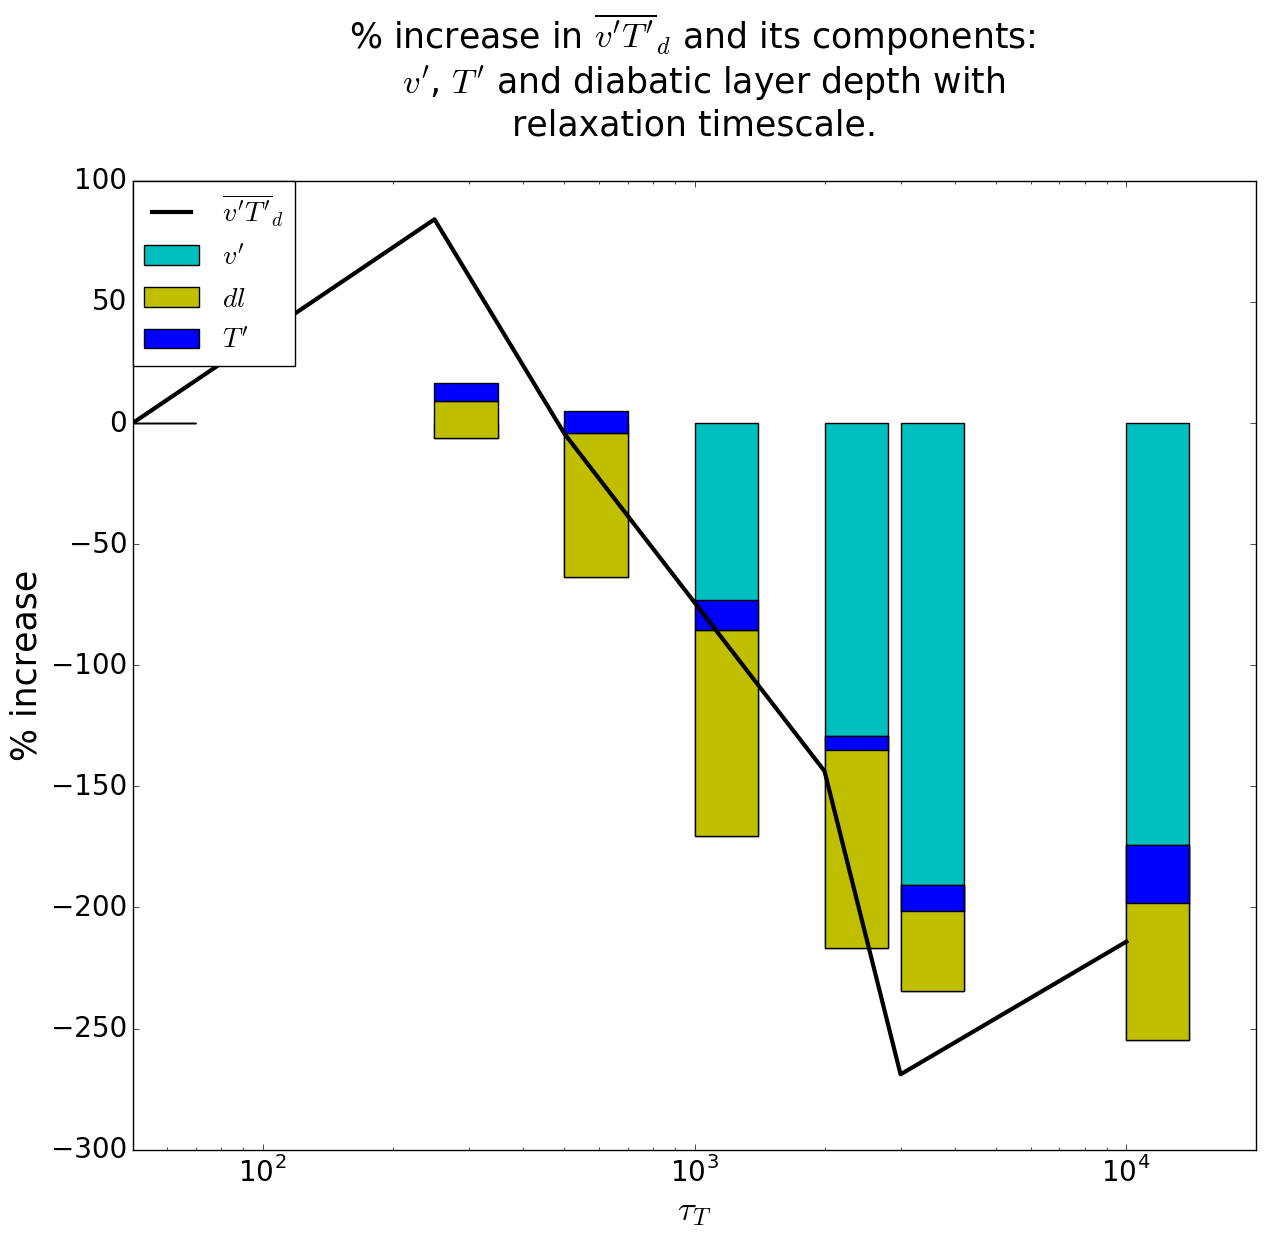

In [61]:
fig = plt.figure(figsize=(14.5, 12.5))
Tau = Tau = [50, 250, 500, 1000 , 2000, 3000, 10000]
tau2 = tau2 = [50, 250, 500, 2000, 3000, 10000]
D1 = Dsum[0:3]
D2 = Dsum[4::]
DD = np.ndarray.tolist(D1) + np.ndarray.tolist(D2)
p = plot(tau2,np.array(DD)*1000,'k',linewidth=3)
p1 = plt.bar(Tau,-Vsum*100,width=np.array(Tau)/2.5, color='c')
p2 = plt.bar(Tau,-Darea*100 , width=np.array(Tau)/2.5, color='y',bottom=-Vsum*100)
p3 = plt.bar(Tau,-APEt*100, width=np.array(Tau)/2.5, color='b',bottom=(-Vsum-Darea)*100)
#ylim(0,1.2)
plt.xscale("log")
plt.xlim(0,2*10**4)
xticks( fontsize=20)
yticks(fontsize=20)
xlabel(r'$\tau _{T}$', fontsize=25)
ylabel(r'% increase', fontsize=25)
title("% increase in $\overline{v^\prime T ^\prime}_{d}$ and its components: \n  $v ^\prime$, $T ^\prime$ and diabatic layer depth with \n relaxation timescale. \n",fontsize=25)
lgd = plt.legend([r'$\overline{v^\prime T ^\prime}_{d}$',r'$v ^\prime$',r'$dl$',r'$T ^\prime$',
                  'Q'], loc=2, borderaxespad=0.,fontsize=20)